In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table
import pdb
import sys

import matplotlib.pyplot as plt
% matplotlib inline

sys.path.insert(0, '/home/oxymoronic/research/GZExpress/analysis/')
from simulation import Simulation

MongoDB: pymongo is not installed. You can still --practise though
MySQLdb: MySQLdb is not installed.


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Please also see GZ2_Nretirement_FOR_REF.py
In that script I compared retirement of GZ2 subjects if they had instead been aggregated at only N votes, with $N \in [9, 15, 20, 25, 30, 35]$. When using the full GZ2 subject set (sans the coadd Stripe 82 subjects), the results look promising: SWAP requires much fewer votes to reach the same level of label accuracy (for the label definitions throughout my paper). However, I felt this was slightly unfair to GZ2 because that is a retired sample of 285K subjects while SWAP only retired 225K in my main simulation. When I select only those subjects that are in both, the SWAP results look pretty bleh.  But this may be unfair to SWAP as it retires "easy" subjects quickly and "hard" subjects take awhile-- and I only ran my simulation for 90 days of GZ2 project data. 

### In this notebook I'll go through steps to be fair to both GZ2 and the SWAP simulation.

In [2]:
sim = Simulation(config="../update_sup_PLPD5_p5_flipfeature2b_norandom2.config", 
				 directory="../S_PLPD5_p5_ff_norand/", 
				 variety='feat_or_not')

In [3]:
candidates = sim.fetchCatalog(sim.fetchFileList(kind='candidate')[-1])
rejected = sim.fetchCatalog(sim.fetchFileList(kind='rejected')[-1])
detected = sim.fetchCatalog(sim.fetchFileList(kind='detected')[-1])
retired = sim.fetchCatalog(sim.fetchFileList(kind='retired')[-1])

### Isolate those subjects in the candidates catalog that are NOT in the retired catalog

In [4]:
# First find subjects the candidates and retired catalogs have in common
common = candidates.merge(retired, on=['zooid'])

# Now select out those subjects in candidates which are not part of the common group
never_retired = candidates[(~candidates.zooid.isin(common.zooid))]

(array([   86.,   887.,  3034.,  5174.,  5352.,  3414.,  1350.,   382.,
           71.,    10.]),
 array([  6. ,   9.9,  13.8,  17.7,  21.6,  25.5,  29.4,  33.3,  37.2,
         41.1,  45. ]),
 <a list of 10 Patch objects>)

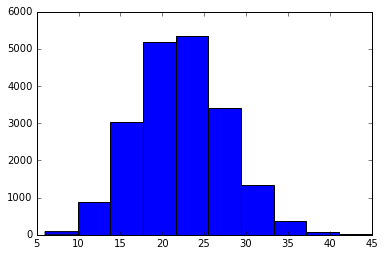

In [5]:
plt.hist(never_retired['Nclass'])

In [8]:
swap_sees = len(retired) + len(never_retired)

In [6]:
# Read in a catalog of ALL GZ2 subjects with all kinds of associated labels
gz2 = pd.read_csv("../GZ2assets_vote_fractions.csv")

In [9]:
swap_never_sees = len(gz2) - swap_sees

In [10]:
print swap_sees, swap_never_sees

245945 49360


In [37]:
# Join retired catalog with GZ2 vote fraction catalog
retired['name'] = retired['zooid']
retired_vf = retired.merge(gz2, on='name')

never_retired['name'] = never_retired['zooid']
never_retired_vf = never_retired.merge(gz2, on='name')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.60000000e+01,   5.30000000e+01,
          1.13000000e+02,   4.36000000e+02,   1.05600000e+03,
          1.96400000e+03,   2.80800000e+03,   2.22500000e+03,
          4.24100000e+03,   3.35500000e+03,   1.74800000e+03,
          9.96000000e+02,   3.40000000e+02,   2.55000000e+02,
          8.50000000e+01,   4.80000000e+01,   9.00000000e+00,
          4.00000000e+00]),
 array([  0. ,   2.8,   5.6,   8.4,  11.2,  14. ,  16.8,  19.6,  22.4,
         25.2,  28. ,  30.8,  33.6,  36.4,  39.2,  42. ,  44.8,  47.6,
         50.4,  53.2,  56. ,  58.8,  61.6,  64.4,  67.2,  70. ]),
 <a list of 1 Patch objects>)

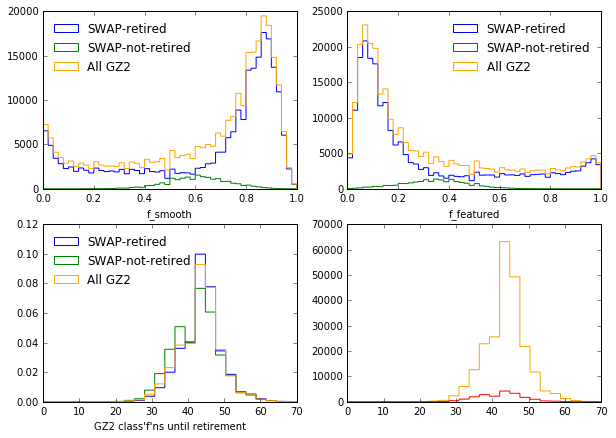

In [80]:
fig = plt.figure(figsize=(10,7))

# Plot vote fraction distributions for SWAP samples against the full GZ2
ax = fig.add_subplot(221)
ax.hist(retired_vf['t01_smooth_or_features_a01_smooth_fraction'], bins=50, range=(0, 1),
        histtype='step', label="SWAP-retired")
ax.hist(never_retired_vf['t01_smooth_or_features_a01_smooth_fraction'], bins=50, range=(0, 1),
        histtype='step', label="SWAP-not-retired")
ax.hist(gz2['t01_smooth_or_features_a01_smooth_fraction'], bins=50, range=(0,1),
        histtype='step', color='orange', label='All GZ2')
ax.legend(loc='upper left', frameon=False)
ax.set_xlabel("f_smooth")

ax = fig.add_subplot(222)
ax.hist(retired_vf['t01_smooth_or_features_a02_features_or_disk_fraction'], bins=50, range=(0, 1),
        histtype='step', label="SWAP-retired")
ax.hist(never_retired_vf['t01_smooth_or_features_a02_features_or_disk_fraction'], bins=50, range=(0, 1),
        histtype='step', label="SWAP-not-retired")
ax.hist(gz2['t01_smooth_or_features_a02_features_or_disk_fraction'], bins=50, range=(0,1),
        histtype='step', color='orange', label='All GZ2')
ax.legend(loc='upper right', frameon=False)
ax.set_xlabel("f_featured")


# Plot votes till retirement for SWAP samples against full GZ2
ax = fig.add_subplot(223)
ax.hist(retired_vf['total_classifications'], normed=True, bins=25, range=(0, 70), 
        histtype='step', label="SWAP-retired")
ax.hist(never_retired_vf['total_classifications'], normed=True, bins=25, range=(0, 70), 
        histtype='step', label="SWAP-not-retired")
ax.hist(gz2['total_classifications'], normed=True,bins=25, range=(0, 70), 
        histtype='step', color='orange', label="All GZ2")
ax.legend(loc='upper left', frameon=False)
ax.set_xlabel("GZ2 class'f'ns until retirement")
ax.set_ylim(0, .12)

ax = fig.add_subplot(224)
#ax.hist(retired_vf['Nclass'], bins=25, range=(0, 70), histtype='step')
#ax.hist(never_retired_vf['Nclass'], bins=25, range=(0, 70), 
#        histtype='step', color='green')
ax.hist(retired_vf['total_classifications'], bins=25, range=(0, 70), 
        histtype='step', color='orange')
ax.hist(never_retired_vf['total_classifications'], bins=25, range=(0, 70), 
        histtype='step', color='red')


In [81]:
from scipy.stats import ks_2samp

ks_2samp(retired_vf['total_classifications'].dropna(), 
         gz2['total_classifications'].dropna())

(0.027736087684878813, 7.3841866728243594e-85)

In [77]:
ks_2samp(never_retired_vf['total_classifications'].dropna(), 
         gz2['total_classifications'].dropna())

(0.10552529486778534, 1.870204793730455e-179)

### I don't know what this tells us. 
The top figures tell us that of those that have not yet retired, most of them are bordering on smooth, but only just. This could be suggestive that these subjects are more difficult to classify and thus why they linger in SWAP. 

The bottom left figure tell us that the vote-per-subject distribution for those SWAP sujects that never retired are disproportionately skewed towards FEWER gz2 votes. Perhaps these are the subjects that are most often misclassified: They have too few votes in the original GZ2 but they are difficult to classify and thus SWAP keeps them around for a disproportionately long time. Except that these subjects were never included in my accuracy analysis so I'm not sure what this says. 

## Is there are a range of GZ2(9) accuracies for random SWAP-retired-sized samples?

In [106]:
gz2_meta = pd.read_csv("../multi-threshold_GZ2_labels.csv")
gz2_labels = pd.read_csv("../asset_agg9votes_task1.csv")

gz2 = gz2.merge(gz2_labels, on='name')

In [96]:
gz2.columns

Index([u'id', u'name', u'total_classifications',
       u't01_smooth_or_features_a01_smooth_fraction',
       u't01_smooth_or_features_a02_features_or_disk_fraction',
       u't01_smooth_or_features_a03_star_or_artifact_fraction',
       u'Unnamed: 0_x', u'GZ2_raw_label_0.2', u'GZ2_weighted_label_0.2',
       u'GZ2_debiased_label_0.2', u'GZ2_raw_label_0.3',
       u'GZ2_weighted_label_0.3', u'GZ2_debiased_label_0.3',
       u'GZ2_raw_label_0.4', u'GZ2_weighted_label_0.4',
       u'GZ2_debiased_label_0.4', u'GZ2_raw_label_0.5',
       u'GZ2_weighted_label_0.5', u'GZ2_debiased_label_0.5', u'SDSS_id',
       u'asset_id_x', u'Unnamed: 0_y', u'asset_id_y', u'smooth_count',
       u'feature_count', u'star_count', u'total_votes', u'smooth_fraction',
       u'feature_fraction', u'star_fraction', u'GZ2_raw9label_0.5'],
      dtype='object')

In [101]:
accuracy = []

N = 100

for n in range(N):
    random_idx = np.random.choice(np.array(len(gz2)), np.array(len(retired)))
    random_sample = gz2.loc[random_idx]
    
    
    accuracy.append(np.sum(random_sample['GZ2_raw9label_0.5'] == 
                           random_sample['GZ2_raw_label_0.5'])/float(len(random_sample)))


(array([  3.,   3.,   9.,  13.,  18.,  16.,  12.,  14.,  10.,   2.]),
 array([ 0.89879081,  0.89908836,  0.8993859 ,  0.89968344,  0.89998099,
         0.90027853,  0.90057608,  0.90087362,  0.90117117,  0.90146871,
         0.90176625]),
 <a list of 10 Patch objects>)

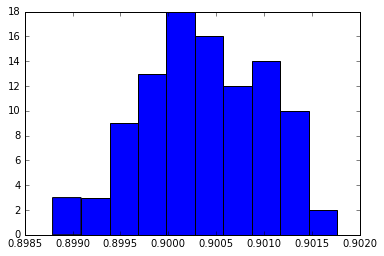

In [102]:
plt.hist(accuracy)

In [107]:
retired = retired.merge(gz2_labels, on='name')
retired = retired.merge(gz2_meta, on='name')

np.sum(retired['GZ2_raw9label_0.5'] == 
       retired['GZ2_raw_label_0.5'])/float(len(retired))


KeyError: 'name'